In [4]:
import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
from shutil import rmtree
from itertools import islice
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

# Task 1

In [5]:
from data_preparation import read_images, un_normalize
from model import get_model, get_batch, similarity, gen_train_input_fn, get_hist, eval_model

## Loading Data

In [6]:
N_CLASSES = len(os.listdir('dataset/coarse/'))

coarse = read_images('dataset/coarse/')
fine = read_images('dataset/fine/')
real = read_images('dataset/real/')
train_idxs = ()
with open('dataset/real/training_split.txt') as f:
    train_idxs = set(int(x) for x in f.read().split(', '))
test_idxs = set(range(len(real))) - train_idxs
Sdb    = coarse
Strain = fine + [real[i] for i in train_idxs]
Stest  = [real[i] for i in test_idxs]
random.shuffle(Sdb)
random.shuffle(Strain)
random.shuffle(Stest)

Dataset = {
    'Sdb': Sdb,
    'Strain': Strain,
    'Stest': Stest
}

## Batch Generator

In [7]:
def get_batch_(Sdb, Strain, verbose = True):
    """
    Generates a batch of `n` elements
    """
    def gen():
        anchors = Strain[:]
        while True:
            if verbose: print('Shuffling dataset')
            random.shuffle(anchors)
            
            for anchor in anchors:
                # Anchor: select random sample from Strain
                #anchor = random.choice(Strain)
                # Puller: select most similar from Sdb
                puller = min( (x for x in Sdb if x.cls == anchor.cls)
                            , key = lambda x: similarity(x.quat,anchor.quat))
                # Pusher: same object different pose | random different object 
                pusher = random.choice([x for x in Sdb 
                                        if (x.cls != anchor.cls) or (x.cls == anchor.cls and x.idx != anchor.idx) ])
                yield (anchor.img, anchor.cls)
                yield (puller.img, puller.cls)
                yield (pusher.img, pusher.cls)
    return gen

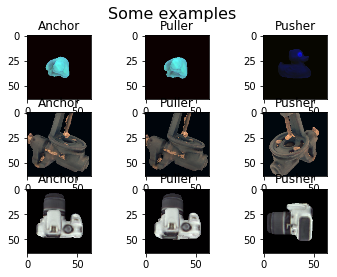

In [8]:
N = 3
imgs = islice((un_normalize(x) for x,_ in get_batch(Sdb, Strain, False)()),9)
fig, ax = plt.subplots(N,3)
for i in range(N):
    fig.suptitle('Some examples', fontsize=16)
    ax[i,0].set_title('Anchor')
    ax[i,0].imshow(next(imgs))
    ax[i,1].set_title('Puller')
    ax[i,1].imshow(next(imgs))
    ax[i,2].set_title('Pusher')
    ax[i,2].imshow(next(imgs))

# Task 2

Creating the neural network

### Cache

In [9]:
if __name__ == '__main__':
    CACHE_DIR = 'cache/'
    rmtree(CACHE_DIR)
    os.makedirs(CACHE_DIR)
    MODEL_PATH = os.path.join(CACHE_DIR,'cnn_model')
    INPUT_PATH = os.path.join(CACHE_DIR,'cnn_input')
    os.makedirs(MODEL_PATH)
    os.makedirs(INPUT_PATH)

In [14]:
# parameters
BATCH_SIZE = 60
MAX_STEPS  = 10000

In [76]:
print('Preparing model...', end='')
cnn_descriptor = get_model(Dataset)
hists = []
print('\rModel trained.')
print('Executing model')
with open('hists.csv', 'w+') as f:
    f.write('epochs,<10,<20,<40,<180\n')

tensors_to_log = [
    'triplet_loss',
    'pair_loss',
    'full_loss'
]
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=10)

input_fn = gen_train_input_fn(Sdb, Strain, BATCH_SIZE)
for x in range(1,MAX_STEPS, 1000):
    print('Step {}/{}'.format(x, MAX_STEPS))
    cnn_descriptor.train(
        input_fn=input_fn,
        max_steps=x
    )
    
    hist = 100 * get_hist(cnn_descriptor, Sdb, Stest) / len(Stest)
    print(hist)
    with open('hists.csv', 'a+') as f:
        arr = [str(x)] + list(map(str,hist))
        f.write(','.join(arr) + '\n')


Preparing model...INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'cache/cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a5959a3c8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Model trained.
Executing model
Step 1/10000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tens

NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key beta1_power not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-76-4fcbd42d45ed>:22)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-76-4fcbd42d45ed>", line 22, in <module>
    max_steps=x
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 354, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 1207, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 1241, in _train_model_default
    saving_listeners)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 1468, in _train_with_estimator_spec
    log_step_count_steps=log_step_count_steps) as mon_sess:
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 504, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 921, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 643, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1107, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1112, in _create_session
    return self._sess_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 800, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 557, in create_session
    self._scaffold.finalize()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 215, in finalize
    self._saver.build()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 789, in _build_internal
    restore_sequentially, reshape)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 459, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 862, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1466, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key beta1_power not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-76-4fcbd42d45ed>:22)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


# Task 3

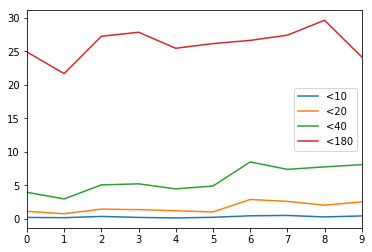

In [71]:
def plot_histograms(filename = 'hists.csv'):
    df = pd.read_csv(filename)
    return df.drop('epochs',axis=1).plot()
plot_histograms()

In [75]:
def project_data(model, Stest):
    imgs, labs = zip(*[(x.img, x.cls) for x in Stest])
    imgarr = np.array(imgs)
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        imgarr,
        shuffle=False,
    )
    descs = np.array(list(model.predict(eval_input_fn)))

    #descriptors = tf.convert_to_tensor(descs)
    images = tf.Variable(descs, name='descriptors')
    metadata = os.path.join(MODEL_PATH, 'd' ,'metadata.tsv')
    with open(metadata, 'w') as f:
        for cls in labs:
            f.write(str(cls) + '\n')

    with tf.Session() as sess:
        saver = tf.train.Saver([images])
        sess.run(images.initializer)
        saver.save(sess, os.path.join(MODEL_PATH, 'descriptors.ckpt'))
project_data(Stest)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/descriptors.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key conv2d/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-75-5e936621a6c1>:8)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-5e936621a6c1>", line 21, in <module>
    project_data(Stest)
  File "<ipython-input-75-5e936621a6c1>", line 8, in project_data
    descs = np.array(list(cnn_descriptor.predict(eval_input_fn)))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 593, in predict
    hooks=all_hooks) as mon_sess:
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 921, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 643, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1107, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1112, in _create_session
    return self._sess_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 800, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 557, in create_session
    self._scaffold.finalize()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 213, in finalize
    self._saver = training_saver._get_saver_or_default()  # pylint: disable=protected-access
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in _get_saver_or_default
    saver = Saver(sharded=True, allow_empty=True)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1102, in __init__
    self.build()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 789, in _build_internal
    restore_sequentially, reshape)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 459, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 862, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1466, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key conv2d/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-75-5e936621a6c1>:8)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


In [73]:
def plot_confusion_matrix(model, Sdb, Stest):
    neigh = KNeighborsClassifier(n_neighbors=1)

    Sdb_descriptors, Stest_descriptors = eval_model(model, Sdb, Stest)
    X, y = Sdb_descriptors, [x.cls for x in Sdb]
    neigh.fit(X,y)

    idxs = neigh.kneighbors(Stest_descriptors)[1]

    matrix = np.zeros(N_CLASSES, N_CLASSES)
    N = len(Stest_descriptors)
    for i in range(N):
        db = Sdb[idxs[i][0]]
        test = Stest[i]
        
        cls_true = db.cls
        cls_pred = test.cls
        matrix[cls_true,cls_pred] += 1
        
    return matrix/N

In [74]:
plot_confusion_matrix(cnn_descriptor, Sdb, Stest)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/descriptors.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key conv2d/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at /Users/kanales/Documents/Uni/TDCV/exercise03/model.py:196)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-661e453fbeab>", line 1, in <module>
    plot_confusion_matrix(cnn_descriptor, Sdb, Stest)
  File "<ipython-input-73-57da3ce686a9>", line 4, in plot_confusion_matrix
    Sdb_descriptors, Stest_descriptors = eval_model(model, Sdb, Stest)
  File "/Users/kanales/Documents/Uni/TDCV/exercise03/model.py", line 196, in eval_model
    Sdb_descriptors = list(model.predict(input_fn=eval_input_fn))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 593, in predict
    hooks=all_hooks) as mon_sess:
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 921, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 643, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1107, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1112, in _create_session
    return self._sess_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 800, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 557, in create_session
    self._scaffold.finalize()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 213, in finalize
    self._saver = training_saver._get_saver_or_default()  # pylint: disable=protected-access
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in _get_saver_or_default
    saver = Saver(sharded=True, allow_empty=True)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1102, in __init__
    self.build()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 789, in _build_internal
    restore_sequentially, reshape)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 459, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 862, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1466, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key conv2d/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at /Users/kanales/Documents/Uni/TDCV/exercise03/model.py:196)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
